# DEPENDENCIES FOR BNN USING HMC
**Abbreviations**:

- ANN: Artificial Neural Network
- BNN: Bayesian Neural Network
- HMC: Hamiltonian Monte Carlo

# Necessary Imports

In [2]:
import os # For file-handling functions, e.g. storing model weights, samples and predictions
import keras
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# To handle statistical distributions:
tfd = tfp.distributions

# Loading the predefined synthetic regression problems:
if __name__ == '__main__':
    import import_ipynb
    N = import_ipynb.NotebookLoader(path=['.'])
    N.load_module('dependencies_for_data_generation')
    from dependencies_for_data_generation import *

importing Jupyter notebook from .\dependencies_for_data_generation.ipynb


# Class for Wrapping Functional Model

In [45]:
class FunctionalModel:
    def __init__(self, lr=0.01, random_normal_initializer=False):
        # Storing certain parameters for future reference:
        self.lr = lr
        self.random_normal_initializer = random_normal_initializer

        #------------------------------------
        # Building model:
        if random_normal_initializer:
            initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.0) # To initialise the hidden weights
        else:
            initializer = None
        self.model = keras.Sequential([
            keras.layers.Input((1,)),
            keras.layers.Dense(100, activation='relu', kernel_initializer=initializer),
            keras.layers.Dense(100, activation='relu', kernel_initializer=initializer),
            keras.layers.Dense(1)])
        
        #------------------------------------
        # Compiling the model with the appropriate loss functions and optimisers:

        # Optimizer:
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        # Loss function:
        loss = keras.losses.MeanSquaredError()
        # Compiling the model:
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        #------------------------------------
        # INITIALISING MODEL WEIGHTS
        
        self.model_weights = self.model.get_weights()
        # NOTE 1: This is done in case the `self.fit` was not run before HMC sampling
        # NOTE 2: The reason for storing weights like this is given in the implementation note below this code block

        self.initial_model_weights = self.model.get_weights()
        # NOTE: This is done in case we want to reset one or more of the model's layers after training

    #================================================
    # WRAPPER FUNCTION FOR MODEL FITTING
    
    def enhanced_fit(self, x, y, epochs=30, batch_size=2, verbose=False, num_reinitializations=1, problem_id=None):
        # NOTE: `problem_id` helps name the files of the stored model weights
        
        # Creating a callback to store the best model's weights:
        # NOTE: "Best" is evaluated with respect to training loss
        checkpoint_path = f'storage/functional_model--problem_{problem_id}.weights.h5'
        # NOTE: The `.weights.h5` extension above is mandatory
        checkpoint_dir = os.path.dirname(checkpoint_path)
        checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='loss', save_best_only=True, save_weights_only=True, verbose=0, save_freq='epoch')

        #------------------------------------
        # Creating variables to store the "best" model and its loss:
        best_model, best_model_loss = None, float('inf')

        #------------------------------------
        for i in range(num_reinitializations):
            # Fitting the model:
            history = self.model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpoint])
            #________________________
            # Loading the best model's weights (as stored using the `checkpoint` callback):
            self.model.load_weights(f'storage/functional_model--problem_{problem_id}.weights.h5')
            #________________________
            # Assigning the above model to `best_model` if its minimum loss is lesser:
            min_training_loss = min(history.history['loss'])
            if min_training_loss < best_model_loss:
                best_model, best_model_loss = self.model, min_training_loss
            '''
            NOTE: Why check minimum loss encountered during training?
            We check minimum loss, since because of the way we are loading the weights of the best model in training
            with respect to loss, the loss of the final model is the minimum loss encountered during training.
            '''
            #________________________
            # In case `num_reinitializations` is greater than 1 (which means we musut reinitialise and retrain the model):
            self.model = FunctionalModel(lr=self.lr, random_normal_initializer=self.random_normal_initializer).model # Reinitialising `self.model`

        #------------------------------------
        # Assigning `best_model` to `self.model`:
        self.model = best_model
        
        #------------------------------------
        # Storing the model weights to be used later (see the implementation note below this code block):
        self.model_weights = self.model.get_weights()

    #================================================
    # WRAPPER FUNCTION FOR MODEL SUMMARISATION
    
    def summary(self):
        return self.model.summary()

    #================================================
    # WRAPPER FUNCTION FOR MODEL PREDICTION
    def predict(self, x):
        return self.model.predict(x)

    #================================================
    # FUNCTION TO OBTAIN PREDICTIONS FOR PROPOSED PARAMETER VALUES
    
    def predict_for_proposal(self, x_data, θ, layer):
        # NOTE: `θ` is the proposed tensor of weights to be assigned to layer `layer`.
        
        model_weights_copy = [] # To preserve the original model weights for easy re-running of sampling loop
        for model_weights_layer in self.model_weights:
            model_weights_copy.append(model_weights_layer)
        model_weights_copy[layer] = tf.reshape(θ, self.model_weights[layer].shape)
        # Why reshape the parameter θ? Because θ is to be flattened before HMC sampling. Why? See the implementation notes below.
        self.model.set_weights(model_weights_copy)
        model_predictions = self.model(x_data)
        return model_predictions

> **References**:
>
> - [Customizing what happens in `fit()` (Tensorflow documentation)](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)
> - [_Save and load weights in `keras`_ from **stackoverflow.com**](https://stackoverflow.com/questions/47266383/save-and-load-weights-in-keras)

---

**IMPLEMENTATION NOTE: Why reshape the parameter `θ` in `predict_for_proposal`?**

The proposed weights `θ` for the chosen layer is to be flattened before HMC sampling. The reason for flattening it before passing it as the initial position for the HMC sampler is given in the implementation notes for the `HMC` class defined below (see: [Class for Wrapping HMC Sampler](#Class-for-Wrapping-HMC-Sampler)).

---

**IMPLEMENTATION NOTE: Why store the weights and not simply call `model.get_weights` later?**

When within the HMC sampling loop, as per the implementation we are using, I experienced complications when trying to call `model.get_weights` in the function `predict_for_proposal` (defined above). Based on what I understood, `model.get_weights` relies on the use of Tensor-to-NumPy conversion, but it turns out that to do such a conversion within the sampling loop requires certain settings. In particular, I received the following error:

```
NotImplementedError: numpy() is only available when eager execution is enabled.
```

Maybe a possible solution is to enable eager execution within the model, using `model.run_eagerly = True`, but I prefer to assign the weights array beforehand and just use that array, for the sake of simplicity.

# Global Variables and Functions
The following variables and functions need to be defined globally to conveniently use the HMC sampler defined in `tensorflow_probability`.

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 100)                 │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,401 (40.63 KB)

 Trainable params: 10,401 (40.63 KB)

 Non-trainable params: 0 (0.00 B)

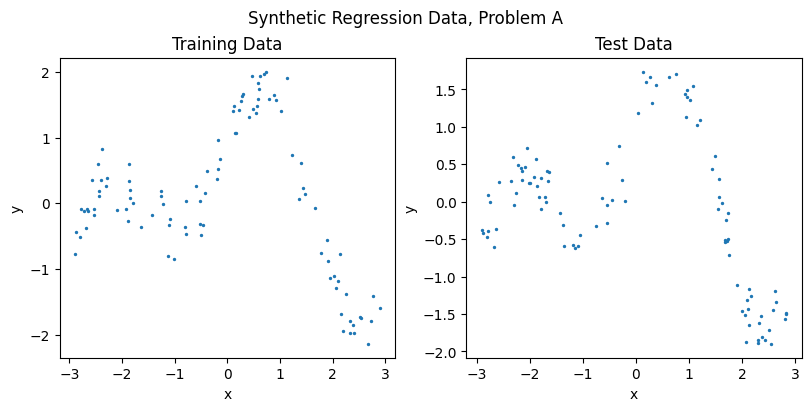

In [54]:
# FUNCTIONAL MODEL
functional_model = FunctionalModel()
if __name__ == '__main__':
    functional_model.summary()

#================================================
# DICTIONARY OF HYPERPARAMETERS FOR THE DISTRIBUTIONS

hyperparams = {'layer':2, 'σ': 1, 'τ': 0.5}
'''
layer : The network layer for which the posterior must be sampled
σ     : Standard deviation for the prior distribution (i.e. assumed scale of the model parameters)
τ     : Standard deviation for the likelihood distribution (i.e. scale of the error terms)
'''

#================================================
# DATA

# Initialising data variables by generating a synthetic problem's data:
x_train, y_train, x_test, y_test = None, None, None, None
if __name__ == '__main__':
    x_train, y_train, x_test, y_test = generate_data('A')

**Functions**:

In [55]:
# MAKING THE PRIOR DISTRIBUTION

def make_prior(dims, σ):
        return tfd.MultivariateNormalDiag(loc=tf.zeros([dims]), scale_diag=σ*tf.ones([dims]))

#================================================
# MAKING THE LIKELIHOOD DISTRIBUTION

def make_likelihood(θ, functional_model, x_data, τ):
    '''
    Calculate the likelihood of the data given the parameters
    ------------------------------------
    INPUT
    θ         : Vector of parameters
    x_data    : Data on which to make the prediction
    τ_squared : Variance of the error term
    '''
    
    # First make a prediction with parameters θ:
    functional_model_prediction = functional_model.predict_for_proposal(x_data, θ, layer=hyperparams['layer'])
    # = f_θ(x), i.e. output of the model parameterised by θ, without error

    # Return the likelihood distribution:
    return tfd.Normal(loc=functional_model_prediction, scale=τ*tf.ones_like(functional_model_prediction))

---

The following may have to be redefined in the file where this module is imported, since it relies on `functional_model` being defined outside its scope.

In [56]:
# RETURNING THE UNNORMALISED LOG-PROBABILITY OF THE POSTERIOR

def unnormalized_log_prob(θ):
    prior = make_prior(dims=θ.shape[0], σ=hyperparams['σ'])
    likelihood = make_likelihood(θ, functional_model, x_train, hyperparams['τ'])
    p = prior.log_prob(θ) + tf.reduce_sum(likelihood.log_prob(y_train))
    return p

# Class for Wrapping HMC Sampler

In [57]:
class HMC:
    def __init__(self, unnormalized_log_prob, functional_model, num_burnin_steps=5000, num_results=10000, num_leapfrog_steps=3, step_size=1.):
        # Setup assumptions:
        self.num_burnin_steps = num_burnin_steps
        self.num_results = num_results # Number of samples to draw
        self.num_leapfrog_steps = num_leapfrog_steps # Number of leapfrog steps from the initial position before proposing a sample
        self.step_size = step_size # Size of each leapfrog step
        self.initialise_kernel(unnormalized_log_prob)

        # Initial position/state of the sampler:
        self.initial_state = tf.reshape(tf.constant(functional_model.model_weights[hyperparams['layer']]), [-1]) # Initial position of the sampler
        # NOTE: Reshaping a tensor into the shape [-1] flattens it. Why do this? See the implementation notes below
    
    #================================================
    # INITIALISING TRANSITION KERNEL
    
    def initialise_kernel(self, unnormalized_log_prob):
        # Defining an simple step size adaptation transition kernel (explained in the notes below):
        self.kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            # The HMC transition kernel is wrapped within the simple step size adaptation transition kernel:
            tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_log_prob,
                num_leapfrog_steps=self.num_leapfrog_steps,
                step_size=self.step_size),
            num_adaptation_steps=int(self.num_burnin_steps*0.8))

    #================================================
    # FUNCTION TO RUN THE MARKOV CHIAN SAMPLER
    
    @tf.function(reduce_retracing=True) # This decorator is explained in the notes below
    def run_chain(self):
        # Run the chain (with burn-in).
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=self.num_results,
            num_burnin_steps=self.num_burnin_steps,
            current_state=self.initial_state,
            kernel=self.kernel,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
        
        # Returning the summary statistics of the samples as well as the samples themselves:
        return samples, is_accepted
        
    #================================================
    # FUNCTION TO FILTER SAMPLES
    
    def get_filtered_samples(self, samples, is_accepted, keep_burnin=False, keep_only_accepted=True):
        filtered_samples = []
        if keep_only_accepted:
            for i in range(self.num_results):
                if is_accepted[i]:
                    filtered_samples.append(samples[i].numpy())
        if not keep_burnin:
            filtered_samples = filtered_samples[self.num_burnin_steps:]
        return tf.constant(np.array(filtered_samples))

**IMPLEMENTATION NOTE: Flattening the initial position of the HMC sampler**:

Notice that during the instantiation of the class, we do the following:

```python
self.initial_state = tf.reshape(tf.constant(functional_model.model_weights[hyperparams['layer']]), [-1])
```

Reshaping a tensor into the shape `[-1]` flattens it (the flattening is done row-wise; a demonstration for such flattening is given below this implementation note). Why do this? Because I want to treat the array of all the weights of the layer chosen as a single parameter to be distributed. However, when the first dimension of the array of weights is greater than 1 (as is the case with a column vector or with a matrix), then the HMC implementation used treats each row as a separate parameter to be distributed. Note that the HMC implementation used here accepts either a single value, a single tensor or a list of tensors, which can also be a tensor of tensors; in the last case, the HMC sampler treats each tensor or row as a single parameter to be distributed, and it samples all the grouped tensors simultaneously and independently (see: [`tfp.mcmc.sample_chain ` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/sample_chain).

This was evident when I ran the HMC sampler for 10000 samples (before applying this flattening approach) with the initial position being a $100 \times 100$ array of weights and obtained the `is_accepted` array as a $10000 \times 100$ array, indicating that each row of the array of weights was treated as an independently distributed parameter. I had the same issue when I put sampled for the output layer's weights, which were stored in a $100 \times 1$ array, i.e. a column vector; here, each element in the column vector was treated as an independently distributed parameter. Hence, my current approach is as follows: I flatten the tensor of weights from layer $i$ that is to be distributed before running the HMC sampler, and when evaluating the sampled weights using the functional model, I reshape the sampled weights according to the shape of layer $i$ in the functional model.

---

**Demonstration of flattening using Tensorflow**:

<u>Code</u>:

```python
A = tf.constant(np.array([[1, 2], [3, 4], [5, 6]]))
print('Before reshape:')
print(A.numpy())
print('\nAfter reshape:')
print(tf.reshape(A, [-1]).numpy())
```

<u>Output</u>:

```
Before reshape:
[[1 2]
 [3 4]
 [5 6]]

After reshape:
[1 2 3 4 5 6]
```

---

**IMPLEMENTATION NOTE: `@tf.function` decorator**:

A tf.function that you define (for example by applying the `@tf.function decorator`) is just like a core TensorFlow operation: You can execute it eagerly; you can compute gradients; and so on.

> **Reference**: [Better performance with `tf.function` (Tensorflow documentation)](https://www.tensorflow.org/guide/function)

---

**CONCEPTUAL NOTE: Transition kernel (a.k.a. Markov kernel)**:

A transition kernel in this context refers to a Markov kernel and pertains to a given Markov chain (note that "Markov chain" = "Markov process"). A transition kernel of a Markov chain is a function that defines the transitions of the Markov chain. Specificallly, it defines the transition probabilities between states in the Markov chain (as a side note, it is a generalisation of the transition matrix in finite state Markov chains).

> **Reference**: [_Markov kernel_, **Wikipedia**](https://en.wikipedia.org/wiki/Markov_kernel)

---

**TECHNICAL NOTE: `tensorflow_probability.mcmc.TransitionKernel`**:

The base class for all MCMC transition kernels. This class defines the minimal requirements to efficiently implement a Markov chain Monte Carlo (MCMC) transition kernel. A transition kernel returns a new state given some old state (as a side note, it also takes and returns additional information which may be used for (a) debugging or (b) optimisation purposes, i.e, to "recycle" previously computed results).

> **Reference**: [`tfp.mcmc.TransitionKernel` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransitionKernel)

---

**IMPLEMENTATION NOTE: `tensorflow_probability.mcmc.SimpleStepSizeAdaptation`**:

It is a subclass of `tensorflow_probability.mcmc.TransitionKernel` that uses a simple policy to adapt the inner kernel's `step_size`, i.e. the size of each transition step from the current state to a proposal state), based on `log_accept_prob`, i.e. the logarithm of the Metropolis acceptance probability (note that logarithms are used since they are more numerically conservative and hence help avoid arithmetic overflow). More precisely, it multiplicatively increases or decreases the `step_size` of the inner kernel based on the value of `log_accept_prob`.

> **Reference**: [`tfp.mcmc.SimpleStepSizeAdaptation` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/SimpleStepSizeAdaptation)

---

**TECHNICAL NOTE: `tfp.mcmc.HamiltonianMonteCarlo`**:

`tfp.mcmc.HamiltonianMonteCarlo` is a subclass of `tensorflow_probability.mcmc.TransitionKernel`, just as HMC is a subclass of MCMC.

# Training the Model as a Traditional ANN

In [58]:
if __name__ == '__main__':
    functional_model.enhanced_fit(x_train, y_train, epochs=30, batch_size=2, verbose=False)

Plotting the results (plotting functions packaged as a function for reusability)...

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


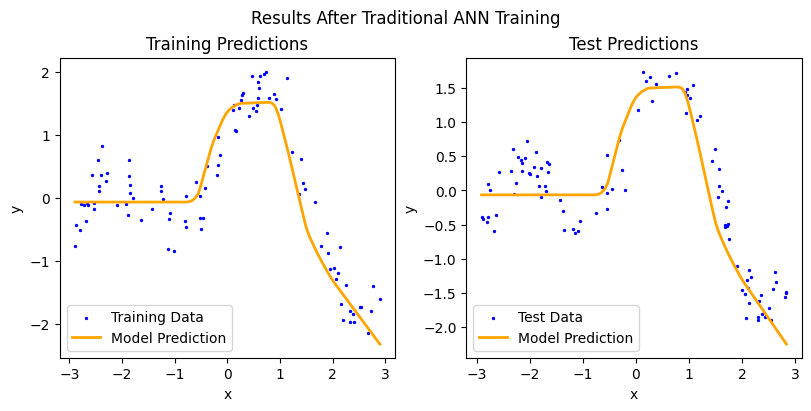

In [59]:
# Function to plot training results:
def plot_ann_train_results(functional_model, x_train, y_train, x_test, y_test, show_suptitle=True):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))

    #------------------------------------
    # Plotting the training data with predictions...
    
    # Plotting the training data:
    axs[0].scatter(x_train, y_train, s=2, color='blue', label='Training Data') 
    
    # Obtaining and plotting predictions for the training range:
    x = np.linspace(min(x_train), max(x_train), 100)
    y_predict = functional_model.predict(x)
    axs[0].plot(x, y_predict, linewidth=2, color='orange', label='Model Prediction')
    
    # Final formatting for the plot:
    axs[0].set_title('Training Predictions')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].legend()

    #------------------------------------
    # Plotting the test data with predictions...

    # Plotting the test data:
    plt.scatter(x_test, y_test, s=2, color='blue', label='Test Data') 
    
    # Obtaining and plotting predictions for the testing range:
    x = np.linspace(min(x_test), max(x_test), 100)
    y_predict = functional_model.predict(x)
    axs[1].plot(x, y_predict, linewidth=2, color='orange', label='Model Prediction')
    
    # Final formatting for the plot:
    axs[1].set_title('Test Predictions')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].legend()

    #------------------------------------
    if show_suptitle:
        plt.suptitle('Results After Traditional ANN Training')
    plt.show()

if __name__ == '__main__':
    plot_ann_train_results(functional_model, x_train, y_train, x_test, y_test)

# Sampling From Posterior of Model Parameters
Note that here, we are only sampling from the posterior of the second layer of weights; all other weights are kept constant.

In [ ]:
# Defining the storage variables in the global scope:
if __name__ == '__main__':
    hmc = HMC(unnormalized_log_prob, functional_model, num_burnin_steps=2500, num_results=5000, num_leapfrog_steps=5, step_size=1.0)
    samples, is_accepted = hmc.run_chain()

Plotting the results...

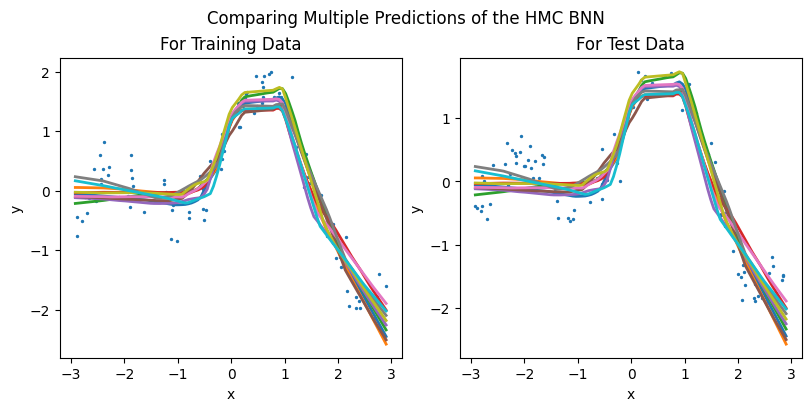

In [61]:
def plot_hmc_results(samples, functional_model, x_train, y_train, x_test, y_test, samples_to_show=3, show_suptitle=True):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
    min_x = min(min(x_train), min(x_test))
    max_x = max(max(x_train), max(x_test))
    x = np.linspace(min_x, max_x, 100)
    y_predictions = []
    
    #------------------------------------
    # Plotting the training data:
    axs[0].scatter(x_train, y_train, s=2, label='Training Data')

    # Obtaining and plotting multiple predictions:
    for i in range(samples_to_show):
        # Picking a random sample:
        random_sample = samples[np.random.choice(samples.shape[0])]
        # Prediction according to the parametrisation based on the above sample:
        y_predictions.append(functional_model.predict_for_proposal(x, random_sample, layer=hyperparams['layer']))
        # Plotting the prediction:
        axs[0].plot(x, y_predictions[-1], linewidth=2)
    
    # Final formatting for the plot:
    axs[0].set_title('For Training Data')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
        
    #------------------------------------
    # Plotting the test data:
    axs[1].scatter(x_test, y_test, s=2, label='Test Data') 
    
    # Obtaining and plotting multiple predictions:
    for y_prediction in y_predictions:
        # Plotting the prediction:
        axs[1].plot(x, y_prediction, linewidth=2)
    
    # Final formatting for the plot:
    axs[1].set_title('For Test Data')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')

    #------------------------------------
    if show_suptitle:
        plt.suptitle('Comparing Multiple Predictions of the HMC BNN')
    plt.show()

if __name__ == '__main__':
    plot_hmc_results(samples, functional_model, x_train, y_train, x_test, y_test, samples_to_show=10)